# Network simulations in Jaxley

In this tutorial, you will learn how to:

- connect neurons into a network  
- visualize networks  

Here is a code snippet which you will learn to understand in this tutorial:
```python
import jaxley as jx
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import connect


# Define a network. `cell` is defined as in previous tutorial.
net = jx.Network([cell for _ in range(11)])

# Define synapses.
fully_connect(
    net.cell(range(10)),
    net.cell(10),
    IonotropicSynapse(),
)

# Visualize the network.
net.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
net.vis(ax=ax, detail="full", layers=[10, 1])  # or `detail="point"`.
```

In the previous tutorial, you learned how to build single cells with morphological detail, how to insert stimuli and recordings, and how to run a first simulation. In this tutorial, we will define networks of multiple cells and connect them with synapses. Let's get started:

In [132]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect

### Define the network

First, we define a cell as you saw in the [previous tutorial](https://jaxleyverse.github.io/jaxley/latest/tutorial/01_morph_neurons/).

In [133]:
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=4)
cell = jx.Cell(branch, parents=[-1, 0, 0, 1, 1, 2, 2])

We can assemble multiple cells into a network by using `jx.Network`, which takes a list of `jx.Cell`s. Here, we assemble 11 cells into a network:

In [134]:
num_cells = 11
net = jx.Network([cell for _ in range(num_cells)])

At this point, we can already visualize this network:

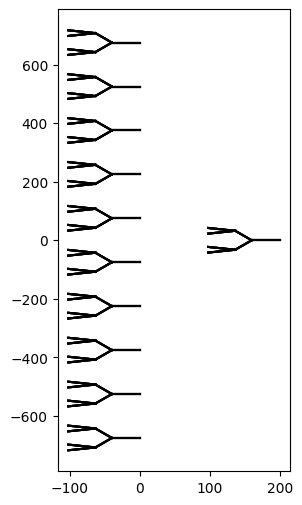

In [135]:
net.compute_xyz()
net.rotate(180)
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full", layers=[10, 1], layer_kwargs={"within_layer_offset": 150, "between_layer_offset": 200})

Note: you can use `move_to` to have more control over the location of cells, e.g.: `network.cell(i).move_to(x=0, y=200)`

As you can see, the neurons are not connected yet. Let's fix this by connecting neurons with synapses. We will build a network consisting of two layers: 10 neurons in the input layer and 1 neuron in the output layer.

We can use `Jaxley`'s `fully_connect` method to connect these layers:

In [136]:
pre = net.cell(range(10))
post = net.cell(10)
fully_connect(pre, post, IonotropicSynapse())

/Users/michaeldeistler/Documents/phd/jaxley/jaxley/modules/base.py:1533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pointer.edges = pd.concat(


Let's visualize this again:

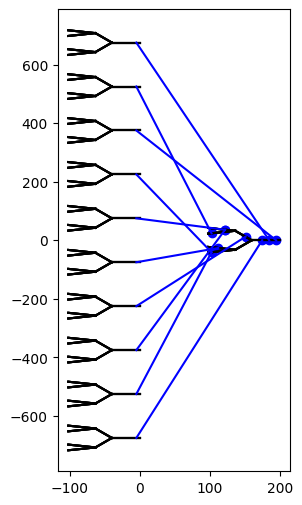

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full", layers=[10, 1], layer_kwargs={"within_layer_offset": 150, "between_layer_offset": 200})

As you can see, the `full_connect` method inserted one synapse (in blue) from every neuron in the first layer to the output neuron. The `fully_connect` method builds this synapse from the zero-eth compartment and zero-eth branch of the presynaptic neuron onto a random branch of the postsynaptic neuron. If you want more control over the pre- and post-synaptic branches, you can use the `connect` method:

In [138]:
pre = net.cell(0).branch(5).loc(1.0)
post = net.cell(10).branch(0).loc(0.0)
connect(pre, post, IonotropicSynapse())

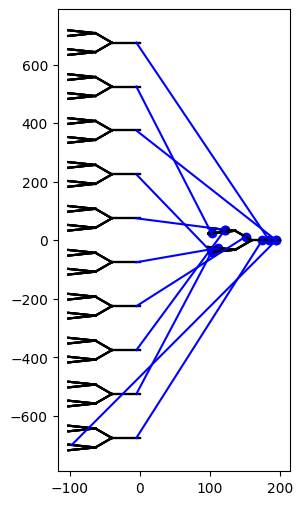

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full", layers=[10, 1], layer_kwargs={"within_layer_offset": 150, "between_layer_offset": 200})

### Stimulating, recording, and simulating the network

We will now set up a simulation of the network. This works exactly as it does for single neurons:

In [140]:
# Stimulus.
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

In [141]:
time_vec = jnp.arange(0.0, t_max + dt, dt)

As a simple example, we insert sodium, potassium, and leak into every compartment of every cell of the network.

In [142]:
net.insert(Na())
net.insert(K())
net.insert(Leak())

We stimulate every neuron in the input layer and record the voltage from the output neuron:

In [143]:
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
net.delete_stimuli()
for stim_ind in range(10):
    net.cell(stim_ind).branch(0).loc(0.0).stimulate(current)

net.delete_recordings()
net.cell(10).branch(0).loc(0.0).record()

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


Finally, we can again run the network simulation and plot the result:

In [144]:
s = jx.integrate(net)

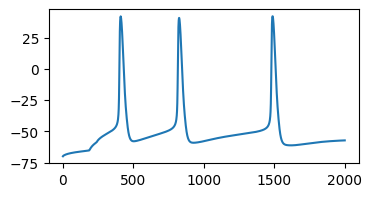

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(s.T)

That's it! You now know how to simulate networks of morphologically detailed neurons. Next, you should learn how to modify parameters of your simulation in [this tutorial](https://jaxleyverse.github.io/jaxley/latest/tutorial/03_setting_parameters/).